In [99]:

# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from feature_extraction import texture_statistics_gabor, bdcn_features, sketch_token_features
from feature_extraction import texture_statistics_pyramid, alexnet_features
from utils import nsd_utils, roi_utils, default_paths

from model_fitting import initialize_fitting as initialize_fitting
from model_fitting import arg_parser as arg_parser
from model_fitting import merge_features, fwrf_fit, fwrf_predict, reconstruct

fpX = np.float32
# device = initialize_fitting.init_cuda()
device = 'cpu:0'
# device = initialize_fitting.init_cuda()

In [115]:
out = torch.load('/user_data/mmhender/imStat/model_fits/S01/alexnet_Conv5_plus_sketch_tokens/Oct-22-2021_1909_57_DEBUG/all_fit_params')




In [100]:
out = torch.load('/user_data/mmhender/imStat/model_fits/S01/alexnet_Conv1/Oct-22-2021_1902_15_DEBUG/all_fit_params')



In [112]:
out = torch.load('/user_data/mmhender/imStat/model_fits/S01/alexnet_Conv1/Oct-22-2021_1859_31_DEBUG/all_fit_params')


In [113]:
out['best_params'][1].shape

(19738, 64, 1)

In [116]:
from plotting import load_fits
load_fits.print_output_summary(out)

subject = 1
volume_space = 1
fitting_type = alexnet
fitting_type2 = sketch_tokens
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (750,)
voxel_index: len 1
voxel_roi: len 4
voxel_ncsnr: shape (699192,)
aperture = 1.0
aperture_rf_range = 1.1
models: shape (875, 3)
best_losses: shape (19738, 3)
best_lambdas: shape (19738, 3)
best_params: len 6
lambdas: shape (9,)
val_cc: shape (19738, 3)
val_r2: shape (19738, 3)
partial_masks: shape (3, 406)
partial_version_names: len 3
zscore_features = True
zscore_in_groups = False
ridge = True
debug = 1
up_to_sess = 1
shuff_rnd_seed = 101922
use_precomputed_prfs = False
alexnet_layer_name = Conv5_ReLU


In [6]:
fitting_type='alexnet';
alexnet_layer_name = 'Conv5_ReLU'

subject=1; volume_space = True; up_to_sess = 1;

n_ori = 4; n_sf = 4; nonlin_fn = False;  padding_mode = 'circular'; \
group_all_hl_feats = True; 

sample_batch_size = 50; voxel_batch_size = 100; \

zscore_features = True; zscore_in_groups = False; ridge = True; \
shuffle_images = False; random_images = False; random_voxel_data = False; \
do_fitting = True; use_precomputed_prfs = False; do_val = True; do_stack=True; \
do_varpart = True; do_roi_recons=False; do_voxel_recons=False; date_str = None; \

shuff_rnd_seed = 0; 
debug = True;

use_pca_st_feats = False; use_lda_st_feats = False; lda_discrim_type = None; \
do_pca_bdcn = True; use_pca_pyr_feats_ll = False; use_pca_pyr_feats_hl = False;\

min_pct_var = 99; max_pc_to_retain = 400; \
max_pc_to_retain_pyr_ll = 100; max_pc_to_retain_pyr_hl = 100;\
map_ind = -1; n_prf_sd_out = 2; mult_patch_by_prf = True; \
downsample_factor = 1.0; do_nms = False

In [68]:
fitting_type = 'pyramid_texture'
fitting_type2 = 'alexnet'
alexnet_layer_name = 'Conv3_ReLU'

In [69]:
if 'pyramid' in fitting_type:
    model_name = initialize_fitting.get_pyramid_model_name(ridge, n_ori, n_sf, use_pca_pyr_feats_ll = use_pca_pyr_feats_ll, use_pca_pyr_feats_hl = use_pca_pyr_feats_hl)
    feature_types_exclude = []
    name1 = 'pyramid_texture'

elif 'gabor_texture' in fitting_type:        
    model_name = initialize_fitting.get_gabor_texture_model_name(ridge, n_ori, n_sf)
    feature_types_exclude = []
    name1 = 'gabor_texture'

elif 'gabor_solo' in fitting_type:        
    model_name = initialize_fitting.get_gabor_solo_model_name(ridge, n_ori, n_sf)
    feature_types_exclude = ['pixel', 'simple_feature_means', 'autocorrs', 'crosscorrs']
    name1 = 'gabor_solo'

elif 'sketch_tokens' in fitting_type:
    if use_pca_st_feats:
        # not allowing both of these to be true
        use_lda_st_feats = False
        lda_discrim_type=None
    model_name = initialize_fitting.get_sketch_tokens_model_name(use_pca_st_feats, \
                                     use_lda_st_feats, lda_discrim_type, max_pc_to_retain)   
    name1 = 'sketch_tokens'

elif 'alexnet' in fitting_type:
    model_name = get_alexnet_model_name(alexnet_layer_name)   
    name1 = 'alexnet'

else:
    raise ValueError('fitting type "%s" not recognized'%fitting_type2)

if fitting_type2 is not None:
    if 'sketch_tokens' in fitting_type2:
        model_name2 = initialize_fitting.get_sketch_tokens_model_name(use_pca_st_feats, use_lda_st_feats, \
                                                                      lda_discrim_type, max_pc_to_retain)   
        name2 = 'sketch_tokens'
    elif 'alexnet' in fitting_type2:
        model_name2 = get_alexnet_model_name(alexnet_layer_name)
        name2 = 'alexnet'
    else: 
        raise ValueError('fitting type 2 "%s" not recognized'%fitting_type2)
    model_name = model_name + '_plus_' + model_name2    



In [70]:
def get_alexnet_model_name(alexnet_layer_name):
    
    if 'ReLU' in alexnet_layer_name:
        name = alexnet_layer_name.split('_')[0]
    else:
        name = alexnet_layer_name
    model_name = 'alexnet_%s'%name
    
    return model_name

In [72]:
if 'pyramid' in fitting_type:

    # Set up the pyramid
    compute_features = False
    _fmaps_fn = texture_statistics_pyramid.steerable_pyramid_extractor(pyr_height = n_sf, n_ori = n_ori)
    # Initialize the "texture" model which builds on first level feature maps
    _feature_extractor = texture_statistics_pyramid.texture_feature_extractor(_fmaps_fn,\
              subject=subject, feature_types_exclude=feature_types_exclude, \
              do_varpart = do_varpart, zscore_in_groups = zscore_in_groups,\
              group_all_hl_feats = group_all_hl_feats, compute_features = compute_features, \
              use_pca_feats_ll = use_pca_pyr_feats_ll, use_pca_feats_hl = use_pca_pyr_feats_hl, \
              min_pct_var = min_pct_var, max_pc_to_retain_ll = max_pc_to_retain_pyr_ll, \
              max_pc_to_retain_hl = max_pc_to_retain_pyr_hl, device=device)
    feature_info = [_feature_extractor.feature_column_labels, _feature_extractor.feature_types_include]

elif 'gabor' in fitting_type:

    # Set up the Gabor filtering modules
    _gabor_ext_complex, _gabor_ext_simple, _fmaps_fn_complex, _fmaps_fn_simple = \
            initialize_fitting.get_gabor_feature_map_fn(n_ori, n_sf,device=device);    
    # Initialize the "texture" model which builds on first level feature maps
    autocorr_output_pix=5
    compute_features = False
    _feature_extractor = texture_statistics_gabor.texture_feature_extractor(_fmaps_fn_complex, _fmaps_fn_simple, \
                                                                            subject=subject,\
                                            autocorr_output_pix=autocorr_output_pix, \
                                            feature_types_exclude=feature_types_exclude, do_varpart=do_varpart, \
                                            group_all_hl_feats=group_all_hl_feats, compute_features = compute_features, \
                                                                            device=device)      
    feature_info = [_feature_extractor.feature_column_labels, _feature_extractor.feature_types_include]

elif 'sketch_tokens' in fitting_type:

    _feature_extractor = sketch_token_features.sketch_token_feature_extractor(subject=subject, device=device,\
             use_pca_feats = use_pca_st_feats, min_pct_var = min_pct_var, max_pc_to_retain = max_pc_to_retain, \
             use_lda_feats = use_lda_st_feats, lda_discrim_type = lda_discrim_type, zscore_in_groups = zscore_in_groups)

elif 'alexnet' in fitting_type:

    if alexnet_layer_name=='all_conv':
        assert(fitting_type2 is None)
        fe = []
        n_layers = 5
        names = ['Conv%d_ReLU'%(ll+1) for ll in range(n_layers)]
        for ll in range(n_layers):
            fe.append(alexnet_feature_extractor(subject=subject, \
                                                         layer_name=names[ll], device=device))
        _feature_extractor = merge_features.combined_feature_extractor(fe, names, do_varpart=do_varpart)

    else:
        _feature_extractor = alexnet_feature_extractor(subject=subject, \
                                                         layer_name=alexnet_layer_name, device=device)


if fitting_type2 is not None:

    if 'sketch_tokens' in fitting_type2:

        _feature_extractor2 = sketch_token_features.sketch_token_feature_extractor(subject=subject, device=device,\
                 use_pca_feats = use_pca_st_feats, min_pct_var = min_pct_var, max_pc_to_retain = max_pc_to_retain, \
                 use_lda_feats = use_lda_st_feats, lda_discrim_type = lda_discrim_type,zscore_in_groups = zscore_in_groups)

    elif 'alexnet' in fitting_type2:
        assert(alexnet_layer_name is not 'all_conv')
        _feature_extractor2 = alexnet_feature_extractor(subject=subject, \
                                                         layer_name=alexnet_layer_name, device=device)


    _feature_extractor = merge_features.combined_feature_extractor([_feature_extractor, _feature_extractor2], \
                                                                       [name1,name2], do_varpart = do_varpart)


Feature types to exclude from the model:
[]
Grouping lower level features:
['pixel_stats' 'mean_magnitudes' 'mean_realparts'
 'marginal_stats_lowpass_recons' 'variance_highpass_resid']
Grouping higher level features:
['magnitude_feature_autocorrs' 'lowpass_recon_autocorrs'
 'highpass_resid_autocorrs' 'magnitude_within_scale_crosscorrs'
 'real_within_scale_crosscorrs' 'magnitude_across_scale_crosscorrs'
 'real_imag_across_scale_crosscorrs'
 'real_spatshift_within_scale_crosscorrs'
 'real_spatshift_across_scale_crosscorrs']


In [61]:
model_name

'texture_pyramid_ridge_4ori_4sf_plus_alexnet_all_conv'

In [7]:
model_name = initialize_fitting.get_alexnet_model_name(alexnet_layer_name)   
name1 = 'alexnet'
model_name

'alexnet_Conv5'

In [62]:
output_dir, fn2save = initialize_fitting.get_save_path(subject, volume_space, model_name, shuffle_images, \
                                                           random_images, random_voxel_data, debug, date_str)
    

Time Stamp: Oct-22-2021_1827_20

Will save final output file to /user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf_plus_alexnet_all_conv/Oct-22-2021_1827_20_DEBUG/



In [12]:
alexnet_layer_name.split('_')[0]

'Conv1'

In [8]:
output_dir, fn2save = initialize_fitting.get_save_path(subject, volume_space, model_name, shuffle_images, \
                                                           random_images, random_voxel_data, debug, date_str)
    

Time Stamp: Oct-22-2021_1810_29

Will save final output file to /user_data/mmhender/imStat/model_fits/S01/alexnet_Conv5/Oct-22-2021_1810_29_DEBUG/



In [9]:
# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, \
                                                        volume_space, include_all=True, include_body=True)

sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, \
                                  sessions=sessions, image_inds_only = True, \
                                  voxel_mask=voxel_mask, volume_space=volume_space, \
                                  zscore_betas_within_sess=zscore_betas_within_sess, \
                              shuffle_images=shuffle_images, random_images=random_images, \
                                random_voxel_data=random_voxel_data)



Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
unique values in face labels:
[-1.  0.  1.  2.  3.  5.]
unique values in place labels:
[-1.  0.  1.  2.  3.]
unique values in body labels:
[-1.  0.  1.  2.  3.]
1987 voxels are defined (differently) in both retinotopic areas and category areas
0 voxels are defined (differently) in both face areas and place areas
490 voxels are defined (differently) in both face areas and body areas
158 voxels are defined (differently) in both place areas and body areas
Including all voxels that are defined within nsdgeneral mask, in addition to roi labels.

19738 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all

In [10]:
# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range) 



Possible lambda values are:
[1.0000000e+00 4.2169652e+00 1.7782795e+01 7.4989418e+01 3.1622775e+02
 1.3335215e+03 5.6234131e+03 2.3713736e+04 1.0000000e+05]
most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [43]:
alexnet_layer_name = 'Conv5_ReLU'
# alexnet_layer_name = 'all_conv'
fitting_type2='sketch_tokens'

if alexnet_layer_name=='all_conv':
    assert(fitting_type2 is None)
    fe = []
    n_layers = 5
    names = ['Conv%d_ReLU'%(ll+1) for ll in range(n_layers)]
    for ll in range(n_layers):
        fe.append(alexnet_feature_extractor(subject=subject, \
                                                     layer_name=names[ll], device=device))
    _feature_extractor = merge_features.combined_feature_extractor(fe, names, do_varpart=do_varpart)

else:
    _feature_extractor = alexnet_feature_extractor(subject=subject, \
                                                     layer_name=alexnet_layer_name, device=device)
    


In [44]:
_feature_extractor2 = sketch_token_features.sketch_token_feature_extractor(subject=subject, device=device,\
                 use_pca_feats = use_pca_st_feats, min_pct_var = min_pct_var, max_pc_to_retain = max_pc_to_retain, \
                 use_lda_feats = use_lda_st_feats, lda_discrim_type = lda_discrim_type,zscore_in_groups = zscore_in_groups)
name2 = 'sketch_tokens'
_feature_extractor = merge_features.combined_feature_extractor([_feature_extractor, _feature_extractor2], \
                                                                       [name1,name2], do_varpart = do_varpart)

In [73]:
_feature_extractor.modules[1].n_features

384

In [74]:
_feature_extractor.init_for_fitting(image_size=(240,240), models=models, dtype=fpX)

Initializing for fitting
Clearing precomputed features from memory.
Initializing for fitting
Clearing features from memory


In [75]:
masks, names = _feature_extractor.get_partial_versions()

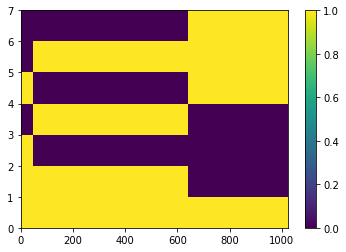

In [76]:
plt.figure();
plt.pcolormesh(masks)
plt.colorbar()

In [77]:
names

['full_combined_model',
 'just_pyramid_texture',
 'pyramid_texture_just_lower-level_no_other_modules',
 'pyramid_texture_just_higher-level_no_other_modules',
 'pyramid_texture_just_lower-level_plus_other_modules',
 'pyramid_texture_just_higher-level_plus_other_modules',
 'just_alexnet']

In [78]:
f, defined = _feature_extractor(image_order_val, models[207,:], 207, fitting_mode = True)

Loading pre-computed features for models [200 - 249] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf.h5py
Took 94.38337 seconds to load file
Size of features array for this batch is:
(62, 641, 50)
Index into batch for prf 207: 7
Size of features array for this image set and prf is:
(62, 641)
Final size of features concatenated is [62 x 641]
Feature types included are:
['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [62 x 641]
Final size of features concatenated is [62 x 641]
Loading pre-computed features for models [200 - 299] from /user_data/mm

/home/mmhender/myenv/lib/python3.7/site-packages/scipy/stats/stats.py:2568: RuntimeWarning: divide by zero encountered in true_divide
  z = (a - mn) / std


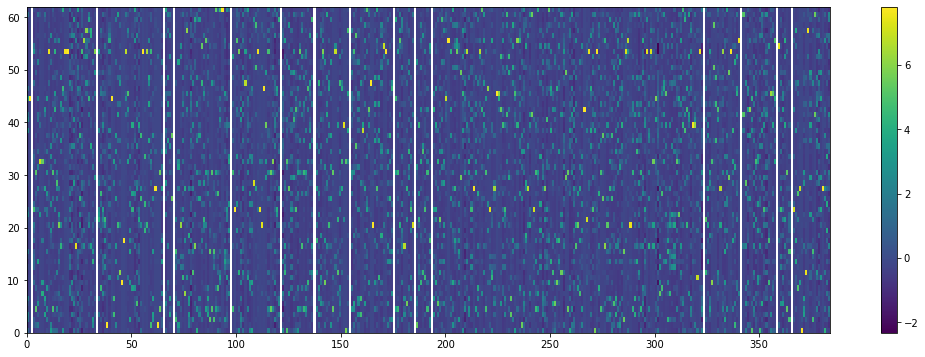

In [94]:
import scipy.stats
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6));
# plt.pcolormesh(f[:,641:]);
plt.pcolormesh(scipy.stats.zscore(f[:,641:], axis=0));
plt.colorbar()

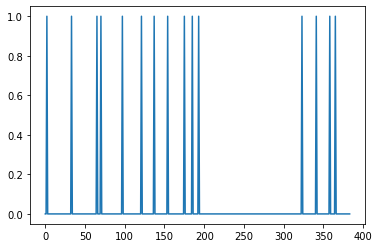

In [98]:
plt.figure();
plt.plot(np.std(f[:,641:].detach().cpu().numpy(), axis=0)==0.0)

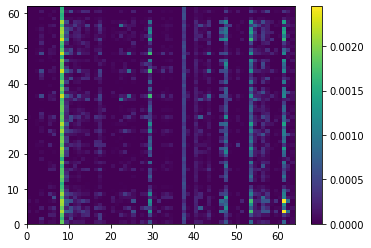

In [25]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(f);
plt.colorbar()

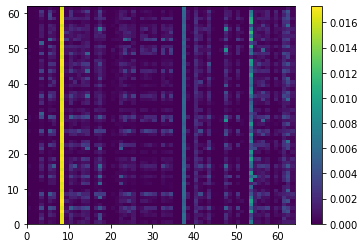

In [27]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(f);
plt.colorbar()

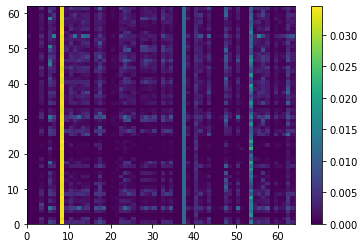

In [29]:
import matplotlib.pyplot as plt
plt.figure();
plt.pcolormesh(f);
plt.colorbar()

In [11]:
import numpy as np
import sys, os
import time
import h5py
import torch.nn as nn


from utils import default_paths, torch_utils
alexnet_feat_path = default_paths.alexnet_feat_path
from feature_extraction import extract_alexnet_features
alexnet_layer_names  = extract_alexnet_features.alexnet_layer_names
n_features_each_layer = extract_alexnet_features.n_features_each_layer

class alexnet_feature_extractor(nn.Module):
    
    def __init__(self, subject, layer_name, device):
        
        super(alexnet_feature_extractor, self).__init__()
        
        self.subject = subject       
        self.layer_name = layer_name
        self.features_file = os.path.join(alexnet_feat_path, 'S%d_%s_features_each_prf.h5py'%(subject, self.layer_name))
        layer_ind = [ll for ll in range(len(alexnet_layer_names)) \
                         if alexnet_layer_names[ll]==self.layer_name]
        assert(len(layer_ind)==1)
        layer_ind = layer_ind[0]
        
        self.n_features = n_features_each_layer[layer_ind]
        if not os.path.exists(self.features_file):
            raise RuntimeError('Looking at %s for precomputed features, not found.'%self.features_file)

        self.device = device
        self.do_varpart=False # only one set of features in this model for now, not doing variance partition

        self.prf_batch_size=100
        self.features_each_prf_batch = None
        self.prf_inds_loaded = []
        
    def init_for_fitting(self, image_size, models, dtype):

        """
        Additional initialization operations.
        """        
        print('Initializing for fitting')
        self.max_features = self.n_features
        
        # Prepare for loading the pre-computed features: as a 
        # compromise between speed and ram usage, will load them in
        # batches of multiple prfs at a time. 
        n_prfs = models.shape[0]
        n_prf_batches = int(np.ceil(n_prfs/self.prf_batch_size))          
        self.prf_batch_inds = [np.arange(self.prf_batch_size*bb, np.min([self.prf_batch_size*(bb+1), n_prfs])) \
                               for bb in range(n_prf_batches)]
       
        self.clear_big_features()
        
    def get_partial_versions(self):

        if not hasattr(self, 'max_features'):
            raise RuntimeError('need to run init_for_fitting first')
           
        partial_version_names = ['full_model']
        masks = np.ones([1,self.max_features])

        return masks, partial_version_names

    def load_precomputed_features(self, image_inds, prf_model_index):
        
        if prf_model_index not in self.prf_inds_loaded:
            
            batch_to_use = np.where([prf_model_index in self.prf_batch_inds[bb] for \
                                         bb in range(len(self.prf_batch_inds))])[0][0]
            assert(prf_model_index in self.prf_batch_inds[batch_to_use])
            self.prf_inds_loaded = self.prf_batch_inds[batch_to_use]
            print('Loading pre-computed features for models [%d - %d] from %s'%(self.prf_batch_inds[batch_to_use][0], \
                                                                              self.prf_batch_inds[batch_to_use][-1], self.features_file))
            self.features_each_prf_batch = None
        
            gc.collect()
            torch.cuda.empty_cache()

            t = time.time()

            # Loading raw features.
            with h5py.File(self.features_file, 'r') as data_set:
                values = np.copy(data_set['/features'][:,:,self.prf_batch_inds[batch_to_use]])
                data_set.close() 
            elapsed = time.time() - t
            print('Took %.5f seconds to load file'%elapsed)

            self.features_each_prf_batch = values[image_inds,:,:]
            values=None
            assert(self.n_features==self.features_each_prf_batch.shape[1])
        
            print('Size of features array for this batch, is:')
            print(self.features_each_prf_batch.shape)
            
        else:
            assert(len(image_inds)==self.features_each_prf_batch.shape[0])
            
        index_into_batch = np.where(prf_model_index==self.prf_inds_loaded)[0][0]
        print('Index into batch for prf %d: %d'%(prf_model_index, index_into_batch))
        features_in_prf = self.features_each_prf_batch[:,:,index_into_batch]
        
        print('Size of features array for this image set and prf is:')
        print(features_in_prf.shape)
        
        return features_in_prf
        

    def clear_big_features(self):
        
        print('Clearing features from memory')
        self.features_each_prf_batch = None 
        self.prf_inds_loaded = []
        gc.collect()
        torch.cuda.empty_cache()
    
    def forward(self, image_inds, prf_params, prf_model_index, fitting_mode = True):
         
        features = self.load_precomputed_features(image_inds, prf_model_index)

        assert(features.shape[0]==len(image_inds))
        print('Final size of feature matrix is:')
        print(features.shape)
        
        features = torch_utils._to_torch(features, self.device)
        
        feature_inds_defined = np.zeros((self.max_features,), dtype=bool)
        feature_inds_defined[0:features.shape[1]] = 1
            
        return features, feature_inds_defined
 